In [1]:
import math
import torch
import itertools
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.autograd import Variable
import torchvision
from torchvision import transforms as transforms


def _bn_function_factory(conv, norm, relu):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = relu(norm(conv(concated_features)))
        return bottleneck_output

    return bn_function
    
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate):
        super(_DenseLayer, self).__init__()
        
        self.add_module('conv0', nn.Conv2d(num_input_features, 4 * growth_rate, kernel_size=3, padding=1)),
        self.add_module('norm0', nn.BatchNorm2d(4 * growth_rate)),
        self.add_module('relu0', nn.ReLU(inplace=True)),
        
        self.add_module('conv1', nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1)),
        self.add_module('norm1', nn.BatchNorm2d(growth_rate)),

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.conv0, self.norm0, self.relu0)
        if any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.norm1(self.conv1(bottleneck_output))
        return new_features


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class _DenseBlock(nn.Module):
    def __init__(self, nChannels, growth_rate, number):
        super(_DenseBlock, self).__init__()
        layer = _DenseLayer(nChannels, growth_rate,)
        self.add_module('denselayer'+number, layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class AntCNN(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 3 or 4 ints) - how many layers in each pooling block
        num_classes (int) - number of classification classes
        small_inputs (bool) - set to True if images are 32x32. Otherwise assumes images are larger.
    """
    def __init__(self, growth_rate=4, block_config=[4, 4, 4], num_classes=7):

        super(AntCNN, self).__init__()
        # First convolution
        
        num_features=32
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_features, kernel_size=3, stride=1, padding=1, bias=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        dense1_1 = _DenseBlock(num_features, growth_rate*block_config[0], '1_1') 
        self.features.add_module('dense1_1', dense1_1)
        num_features = num_features + growth_rate*block_config[0]
        dense1_2 = _DenseBlock(num_features, growth_rate*block_config[0], '1_2')  
        self.features.add_module('dense1_2', dense1_2)
        num_features = num_features + growth_rate*block_config[0]
        dense1_3 = _DenseBlock(num_features, growth_rate*block_config[0], '1_3') 
        self.features.add_module('dense1_3', dense1_3)
        num_features = num_features + growth_rate*block_config[0]
        dense1_4 = _DenseBlock(num_features, growth_rate*block_config[0], '1_4') 
        self.features.add_module('dense1_4', dense1_4)
        num_features = num_features + growth_rate*block_config[0]
        trans1 = _Transition(num_features, num_features)
        self.features.add_module('trans1', trans1)

        dense2_1 = _DenseBlock(num_features, growth_rate*block_config[1], '2_1') 
        self.features.add_module('dense2_1', dense2_1)
        num_features = num_features + growth_rate*block_config[1]
        dense2_2 = _DenseBlock(num_features, growth_rate*block_config[1], '2_2')
        self.features.add_module('dense2_2', dense2_2)
        num_features = num_features + growth_rate*block_config[1]
        dense2_3 = _DenseBlock(num_features, growth_rate*block_config[1], '2_3') 
        self.features.add_module('dense2_3', dense2_3)
        num_features = num_features + growth_rate*block_config[1]
        dense2_4 = _DenseBlock(num_features, growth_rate*block_config[1], '2_4') 
        self.features.add_module('dense2_4', dense2_4)
        num_features = num_features + growth_rate*block_config[1]
        trans2 = _Transition(num_features, num_features)
        self.features.add_module('trans2', trans2)   
        
        dense3_1 = _DenseBlock(num_features, growth_rate*block_config[2], '3_1') 
        self.features.add_module('dense3_1', dense3_1)
        num_features = num_features + growth_rate*block_config[2]
        dense3_2 = _DenseBlock(num_features, growth_rate*block_config[2], '3_2')
        self.features.add_module('dense3_2', dense3_2)
        num_features = num_features + growth_rate*block_config[2]
        dense3_3 = _DenseBlock(num_features, growth_rate*block_config[2], '3_3') 
        self.features.add_module('dense3_3', dense3_3)
        num_features = num_features + growth_rate*block_config[2]
        dense3_4 = _DenseBlock(num_features, growth_rate*block_config[2], '3_4') 
        self.features.add_module('dense3_4', dense3_4)
        num_features = num_features + growth_rate*block_config[2]
        dense3_5 = _DenseBlock(num_features, growth_rate*block_config[2], '3_5') 
        self.features.add_module('dense3_5', dense3_5)
        num_features = num_features + growth_rate*block_config[2]
        dense3_6 = _DenseBlock(num_features, growth_rate*block_config[2], '3_6') 
        self.features.add_module('dense3_6', dense3_6)
        num_features = num_features + growth_rate*block_config[2]
        dense3_7 = _DenseBlock(num_features, growth_rate*block_config[2], '3_7') 
        self.features.add_module('dense3_7', dense3_7)
        num_features = num_features + growth_rate*block_config[2]
        
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        
        for m in self.named_parameters():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=5).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [2]:
def confusion_matrix(preds, y, NUM_CLASSES):
    """ Returns confusion matrix """
    assert preds.shape[0] == y.shape[0], "1 dim of predictions and labels must be equal"
    rounded_preds = torch.argmax(preds,1)
    conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for i in range(rounded_preds.shape[0]):
        predicted_class = rounded_preds[i]
        correct_class = y[i]
        conf_mat[correct_class][predicted_class] += 1
    return conf_mat

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    print ()
    print ()
    print ()
    print ()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')

This is FER2013
[[307.   4.  44.  16.  60.   8.  52.]
 [  9.  41.   3.   1.   0.   0.   1.]
 [ 44.   0. 307.   7.  88.  38.  44.]
 [ 12.   0.  10. 798.  20.  14.  25.]
 [ 34.   0.  62.  20. 381.   5.  92.]
 [  6.   0.  30.  10.   7. 357.   6.]
 [ 19.   3.  26.  25.  72.   7. 474.]]




Confusion matrix, without normalization
[[307   4  44  16  60   8  52]
 [  9  41   3   1   0   0   1]
 [ 44   0 307   7  88  38  44]
 [ 12   0  10 798  20  14  25]
 [ 34   0  62  20 381   5  92]
 [  6   0  30  10   7 357   6]
 [ 19   3  26  25  72   7 474]]






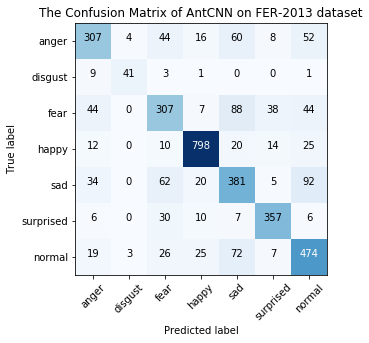

In [3]:
print ("This is FER2013")
from data.fer import FER2013
NUM_CLASSES = 7
cut_size = 44
transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(
            mean=[0.51467806, 0.51467806, 0.51467806], std=[0.24866803, 0.24866803, 0.24866803])
            (transforms.ToTensor()(crop)) for crop in crops])),
])

use_cuda = torch.cuda.is_available()
PrivateTestset = FER2013(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=4, shuffle=False, num_workers=1)

net = AntCNN() 
Private_checkpoint = torch.load('models/FER2013_AntCNN_Augmentation_74.255/PrivateTest_model.t7')
net.load_state_dict(Private_checkpoint['net'], strict=False)

net.cuda()
net.eval()
conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    
    test_bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    outputs = outputs.view(test_bs, ncrops, -1).mean(1)  # avg over crops
    
    conf_mat += confusion_matrix(outputs, targets, NUM_CLASSES)
print (conf_mat)
print ()
print ()
print ()
print ()
attack_types = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'normal']
plt.figure(figsize=(5, 5))
plot_confusion_matrix(conf_mat.astype(int), classes=attack_types, normalize=False, title='')

plt.title('The Confusion Matrix of AntCNN on FER-2013 dataset')
plt.savefig("The Confusion Matrix of AntCNN on FER-2013 dataset.png", bbox_inches = 'tight')
plt.tight_layout()
plt.show()
plt.close()
print ()
print ()
print ()
print ()

This is RAF
[[1.340e+02 5.000e+00 1.000e+00 9.000e+00 2.000e+00 3.000e+00 8.000e+00]
 [1.100e+01 9.000e+01 2.000e+00 1.300e+01 1.700e+01 5.000e+00 2.200e+01]
 [4.000e+00 2.000e+00 4.100e+01 4.000e+00 1.100e+01 8.000e+00 4.000e+00]
 [5.000e+00 3.000e+00 1.000e+00 1.111e+03 8.000e+00 9.000e+00 4.800e+01]
 [4.000e+00 6.000e+00 1.000e+00 9.000e+00 4.120e+02 2.000e+00 4.400e+01]
 [2.000e+00 2.000e+00 6.000e+00 1.100e+01 5.000e+00 2.870e+02 1.600e+01]
 [0.000e+00 6.000e+00 2.000e+00 2.100e+01 4.800e+01 1.200e+01 5.910e+02]]




Confusion matrix, without normalization
[[ 134    5    1    9    2    3    8]
 [  11   90    2   13   17    5   22]
 [   4    2   41    4   11    8    4]
 [   5    3    1 1111    8    9   48]
 [   4    6    1    9  412    2   44]
 [   2    2    6   11    5  287   16]
 [   0    6    2   21   48   12  591]]






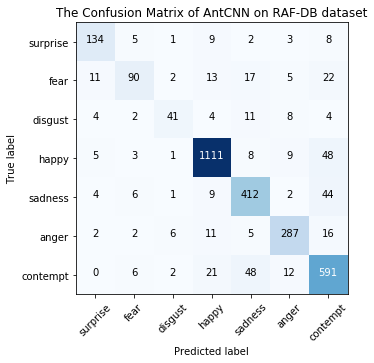

In [4]:
print ("This is RAF")
from data.RAF import RAF
NUM_CLASSES = 7
cut_size = 44
transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(
            mean=[0.589499, 0.45687565, 0.40699387], std=[0.25357702, 0.23312956, 0.23275192])
            (transforms.ToTensor()(crop)) for crop in crops])),
])

use_cuda = torch.cuda.is_available()
PrivateTestset = RAF(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=8, shuffle=False, num_workers=1)

net = AntCNN() 
Private_checkpoint = torch.load('models/RAF_AntCNN_Augmentation_86.90/PrivateTest_model.t7')
net.load_state_dict(Private_checkpoint['net'], strict=False)

net.cuda()
net.eval()
conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    
    test_bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    outputs = outputs.view(test_bs, ncrops, -1).mean(1)  # avg over crops
    
    conf_mat += confusion_matrix(outputs, targets, NUM_CLASSES)
print (conf_mat)
print ()
print ()
print ()
print ()
attack_types = ['surprise', 'fear', 'disgust', 'happy', 'sadness', 'anger', 'contempt']
plt.figure(figsize=(5, 5))
plot_confusion_matrix(conf_mat.astype(int), classes=attack_types, normalize=False, title='')


plt.title('The Confusion Matrix of AntCNN on RAF-DB dataset')
plt.savefig("The Confusion Matrix of AntCNN on RAF-DB dataset.png", bbox_inches = 'tight')
plt.show()
plt.close()
print ()
print ()
print ()
print ()